In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

import jax.numpy as jnp
from jax import random, vmap, pmap, local_devices

import numpy as np
from jax import image

from models import DiscreteVAE
from archs import MLP, periodic_encoding
from utils import restore_checkpoint

from configs.discrete_config import get_config

import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')
%matplotlib inline

print(local_devices())

2023-01-22 14:34:23.539594: E tensorflow/tsl/lib/monitoring/collection_registry.cc:81] Cannot register 2 metrics with the same name: /tensorflow/core/bfc_allocator_delay


[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]


In [2]:
N = 4096
m = 64
num_channels = 1

resize = lambda x: image.resize(x, shape=(m,m,num_channels), method='bilinear')

data_buf = np.load('../cahn_hilliard_patterns.npy')
num_examples = data_buf.shape[0]

key = random.PRNGKey(0)
idx = random.choice(key, num_examples, (N,), replace=False)
train_X = jnp.array(data_buf[idx,...])
train_X = vmap(resize)(train_X)

key = random.PRNGKey(1)
idx = random.choice(key, num_examples, (N,), replace=False)
test_X = jnp.array(data_buf[idx,...])
test_X = vmap(resize)(test_X)

def get_example(u, n):
    u = jnp.flipud(u)
    return u, u, jnp.ones_like(u)

N, m, _, num_channels = train_X.shape

gen_fn = lambda u: get_example(u, m)
u_train, s_train, w_train = vmap(gen_fn)(train_X)
print('Training data')
print('u: {}'.format(u_train.shape))
print('s: {}'.format(s_train.shape))
print('w: {}'.format(w_train.shape))

# Generate testing samples
gen_fn = lambda u: get_example(u, m)
u_test, s_test, w_test = vmap(gen_fn)(test_X)
print('Testing data')
print('u: {}'.format(u_test.shape))
print('s: {}'.format(s_test.shape))
print('w: {}'.format(w_test.shape))

def compute_mmd(config, model, num_samples=256):
    # Generate samples from model
    key = random.PRNGKey(123)
    eps_test = random.normal(key, (num_samples, config.eps_dim))
    sample_fn = lambda params: model.state.decode_fn(params, eps_test)
    samples = pmap(sample_fn)(model.state.params)[0,...]

    def MMD(X, Y, k):
        n = X.shape[0]
        m = Y.shape[0]
        kXX = k(X,X)
        kYY = k(Y,Y)
        kXY = k(X,Y)
        Xterm = 1./(n*(n-1))*jnp.sum(kXX)
        Yterm = 1./(m*(m-1))*jnp.sum(kYY)
        XYterm = 1./(n*m)*jnp.sum(kXY)
        return Xterm + Yterm - 2*XYterm

    dim = samples.shape[1]**2
    kernelfunc = lambda x, y, sigmasq: jnp.exp(- 1./(2*sigmasq*dim) * jnp.dot(x-y, x-y))

    # Define sweep range and containers
    sigmasqs = jnp.linspace(1e-2,10,100)
    def get_mmds(X, Y, sigmasq):
        kernel = lambda x, y: kernelfunc(x, y, sigmasq)
        k = vmap(vmap(kernel, in_axes=(None, 0)), in_axes=(0, None))
        mmd = MMD(X, Y, k)
        return mmd

    mmds = vmap(get_mmds, in_axes=(None,None,0))(samples.reshape(num_samples,-1), 
                                                 s_train[:num_samples,...].reshape(num_samples,-1),
                                                 sigmasqs)
    return mmds    
    


Training data
u: (4096, 64, 64, 1)
s: (4096, 64, 64, 1)
w: (4096, 64, 64, 1)
Testing data
u: (4096, 64, 64, 1)
s: (4096, 64, 64, 1)
w: (4096, 64, 64, 1)


In [3]:
# Load trained model
config = get_config()
model = DiscreteVAE(config)
model = restore_checkpoint(model, '../checkpoints/ch_dVAE_64_beta1e-4_checkpoint_20000')


                            DiscreteOperator Summary                            
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ path          ┃ module        ┃ inputs        ┃ outputs      ┃ params        ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│               │ DiscreteOper… │ -             │ float32[64,… │               │
│               │               │ float32[1,64… │              │               │
│               │               │ - float32[64] │              │               │
├───────────────┼───────────────┼───────────────┼──────────────┼───────────────┤
│ encoder       │ ConvEncoder   │ -             │ -            │               │
│               │               │ float32[1,64… │ float32[64]  │               │
│               │               │ - float32[64] │ - float32[]  │               │
├───────────────┼───────────────┼───────────────┼──────────────┼───────────────┤
│ encoder/Gaus… │ GaussianC

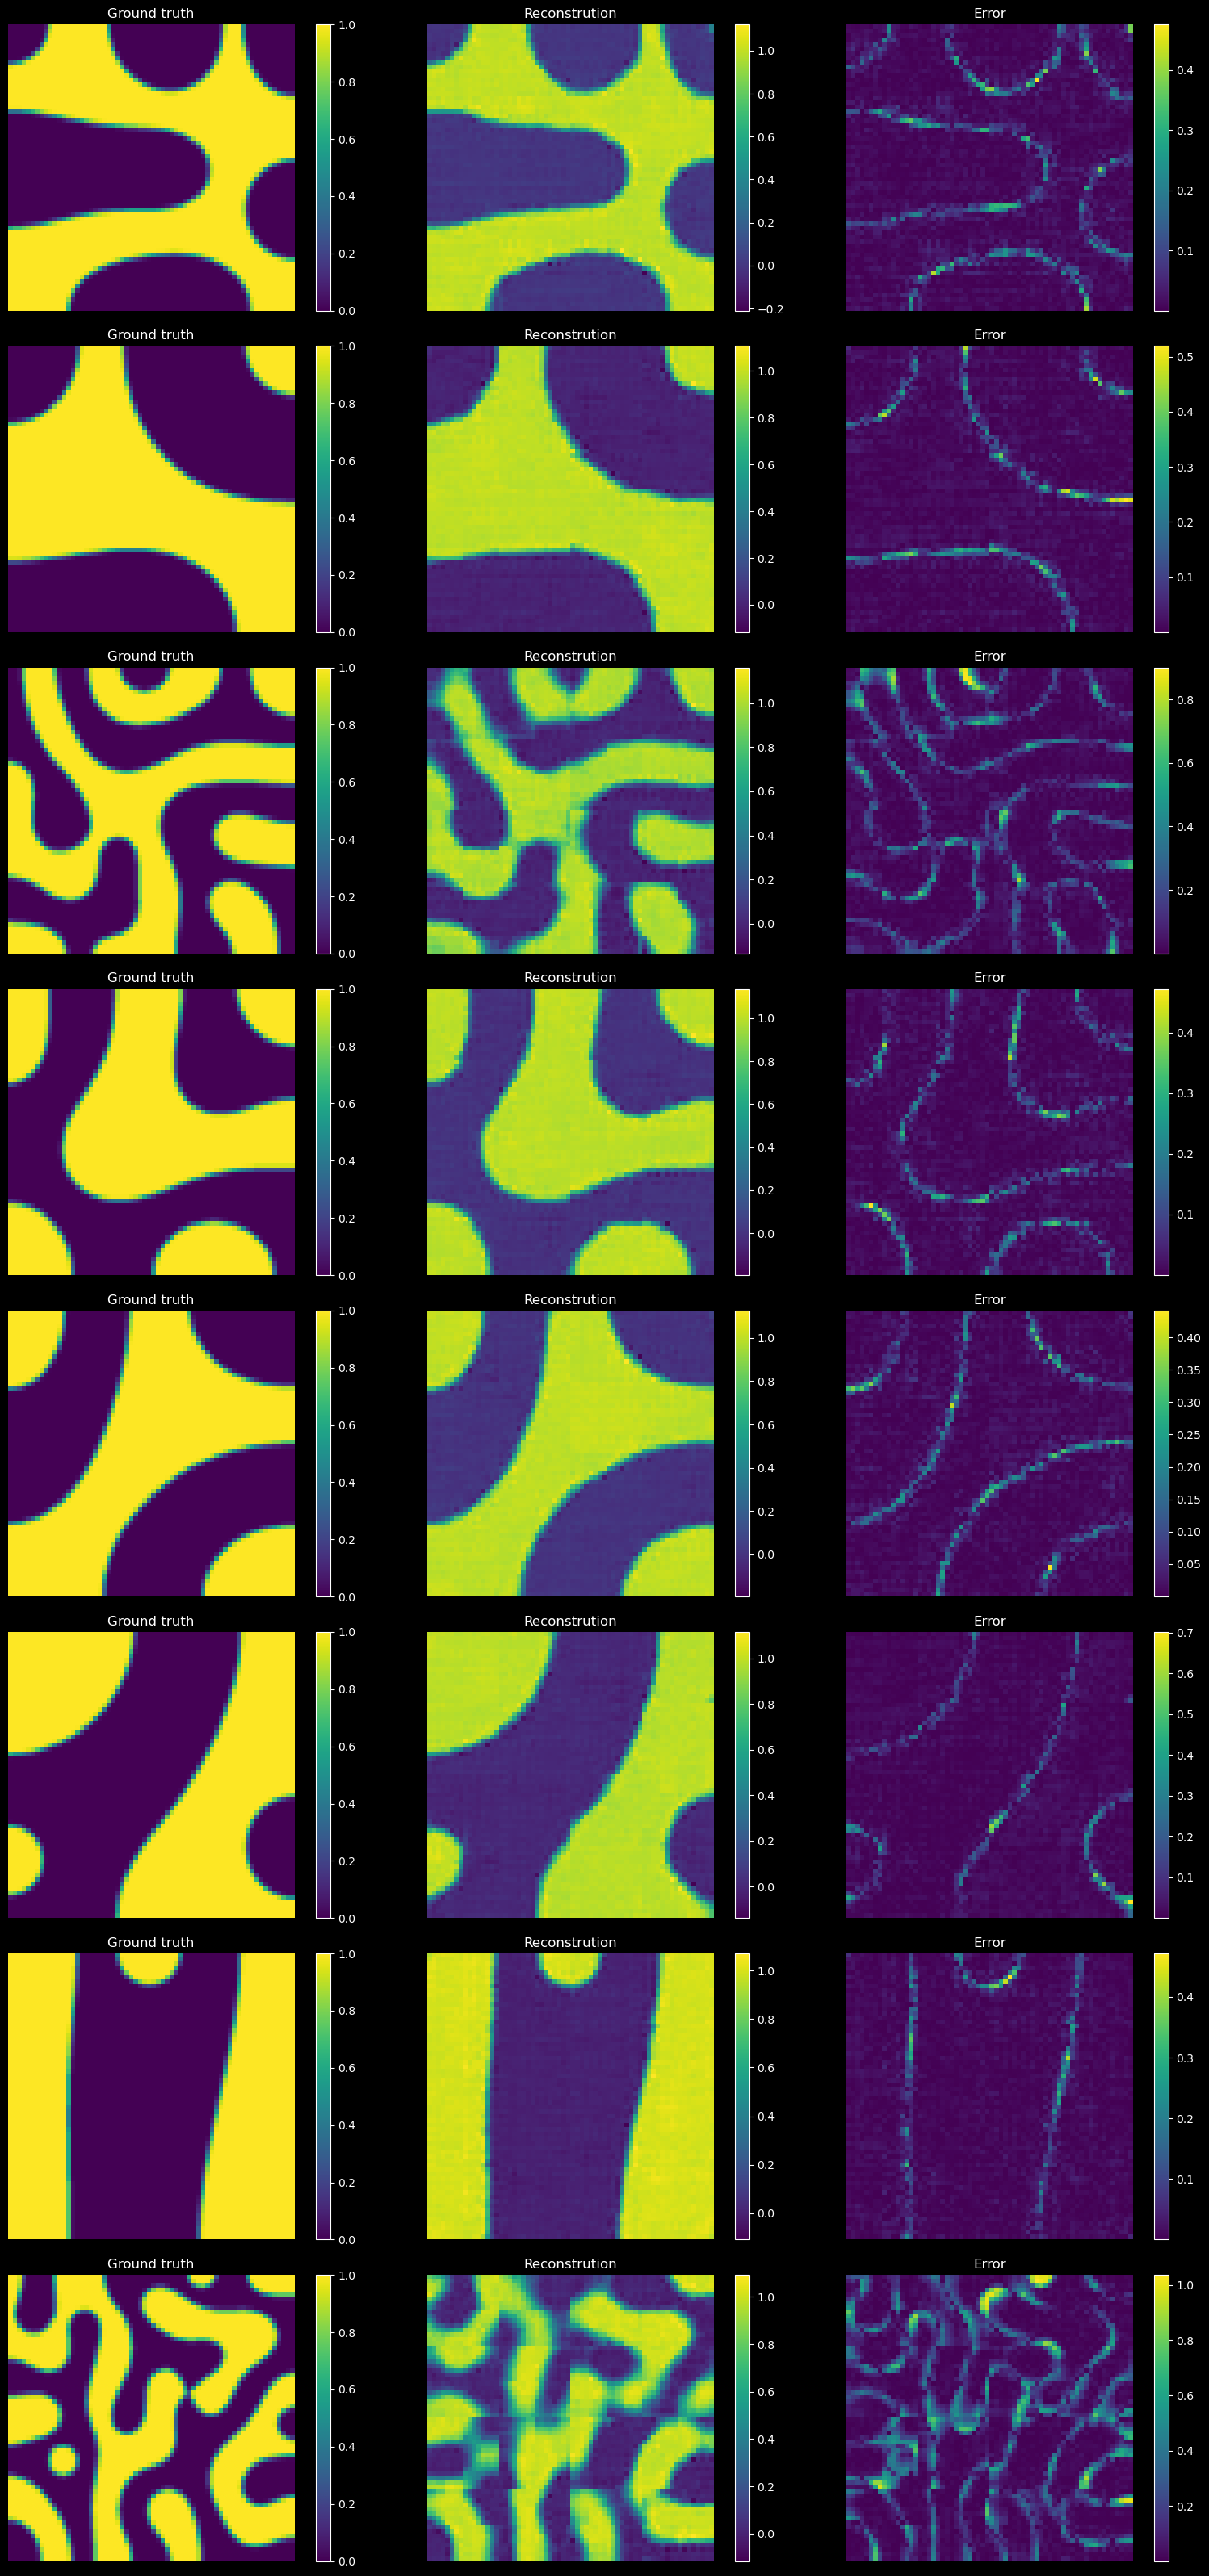

In [4]:
# Train reconstructions
num_samples = 8
key = random.PRNGKey(0)
idx = random.choice(key, N, (num_samples,), replace=False)
eps_train= random.normal(key, (num_samples, config.eps_dim))
pred_fn = lambda params: model.state.apply_fn(params, u_train[idx,...], eps_train)
s_pred = pmap(pred_fn)(model.state.params)[0,...]

num_samples = 8
plt.figure(figsize=(16, num_samples*4))
cnt=0
for i in range(num_samples):
    # Grounf truth
    cnt+=1
    plt.subplot(num_samples, 3, cnt)
    plt.imshow(jnp.flipud(s_train[idx[i],...]))
    plt.colorbar()
    plt.axis('off')
    plt.title('Ground truth')
    # Prediction
    cnt+=1
    plt.subplot(num_samples, 3, cnt)
    plt.imshow(jnp.flipud(s_pred[i,...]))
    plt.colorbar()
    plt.axis('off')
    plt.title('Reconstrution')
    # Error
    cnt+=1
    plt.subplot(num_samples, 3, cnt)
    error = jnp.abs(s_train[idx[i],...] - s_pred[i,...])
    plt.imshow(jnp.flipud(error))
    plt.colorbar()
    plt.axis('off')
    plt.title('Error')
plt.tight_layout()
plt.savefig('./figures/train_reconstructions.png', dpi=300)
plt.show()

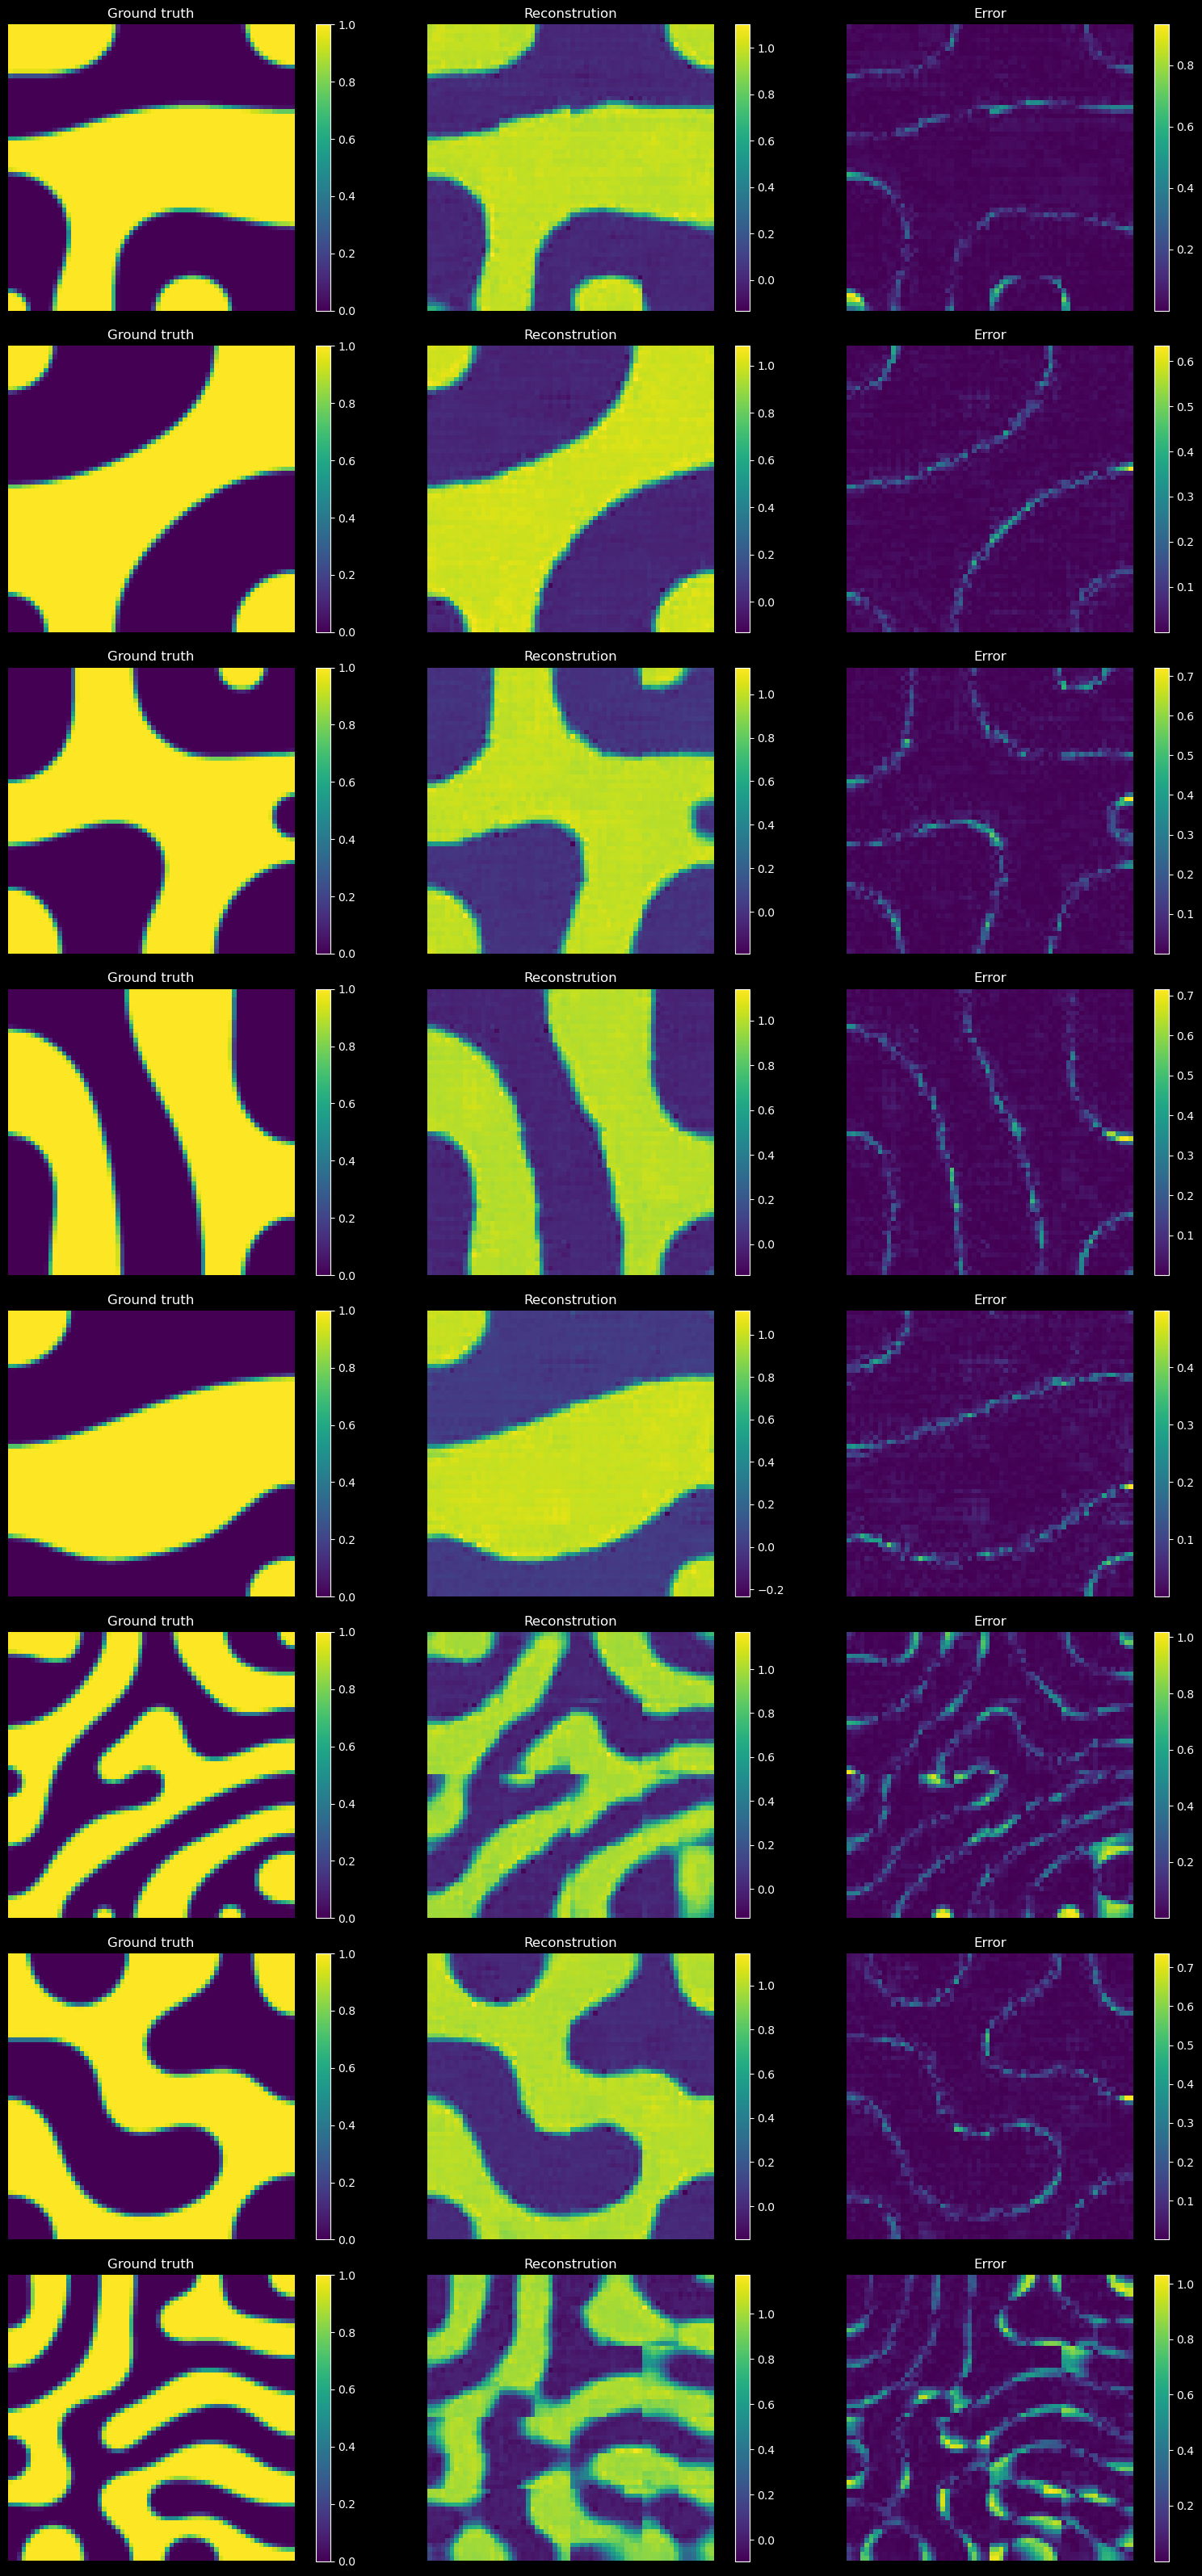

In [5]:
# Test reconstructions
num_samples = 8
key = random.PRNGKey(123)
idx = random.choice(key, N, (num_samples,), replace=False)
eps_test = random.normal(key, (num_samples, config.eps_dim))
pred_fn = lambda params: model.state.apply_fn(params, u_test[idx,...], eps_test)
s_pred = pmap(pred_fn)(model.state.params)[0,...]

num_samples = 8
plt.figure(figsize=(16, num_samples*4))
cnt=0
for i in range(num_samples):
    # Grounf truth
    cnt+=1
    plt.subplot(num_samples, 3, cnt)
    plt.imshow(jnp.flipud(s_test[idx[i],...]))
    plt.colorbar()
    plt.axis('off')
    plt.title('Ground truth')
    # Prediction
    cnt+=1
    plt.subplot(num_samples, 3, cnt)
    plt.imshow(jnp.flipud(s_pred[i,...]))
    plt.colorbar()
    plt.axis('off')
    plt.title('Reconstrution')
    # Error
    cnt+=1
    plt.subplot(num_samples, 3, cnt)
    error = jnp.abs(s_test[idx[i],...] - s_pred[i,...])
    plt.imshow(jnp.flipud(error))
    plt.colorbar()
    plt.axis('off')
    plt.title('Error')
plt.tight_layout()
plt.savefig('./figures/test_reconstructions.png', dpi=300)
plt.show()

(8, 64, 64, 1)


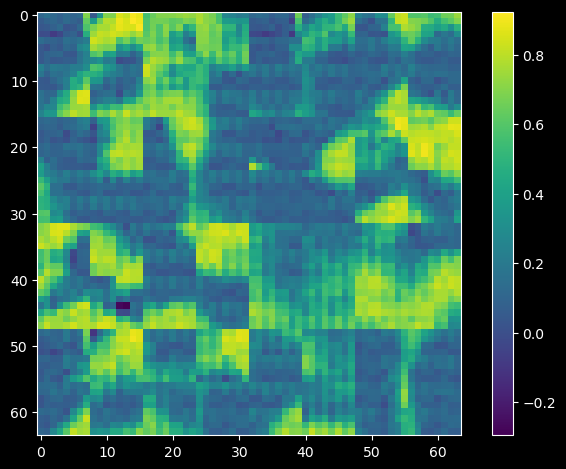

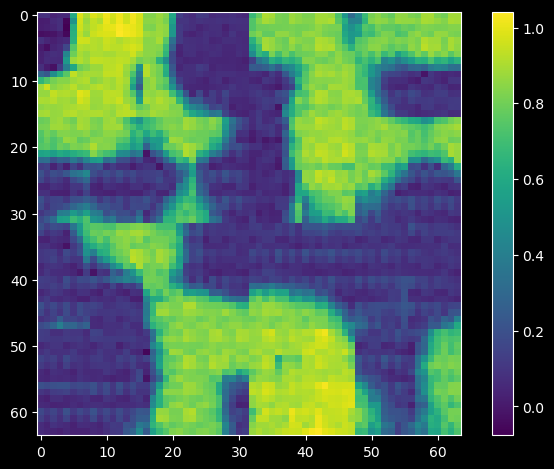

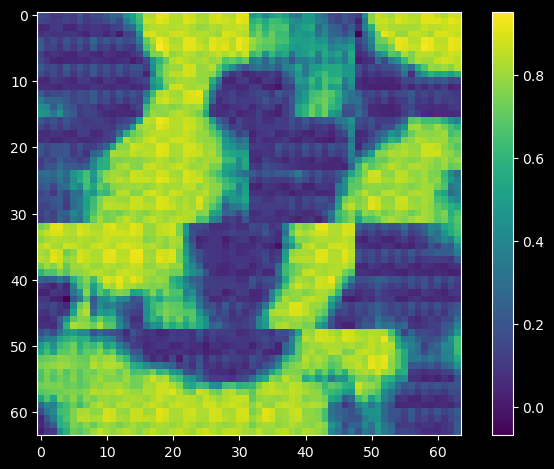

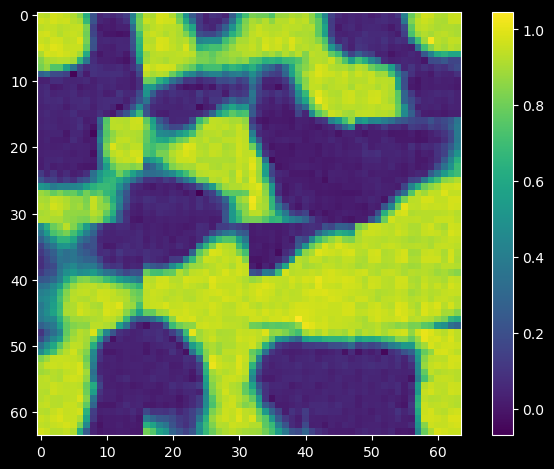

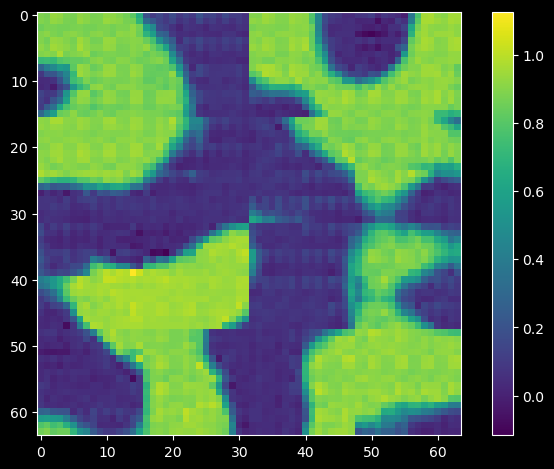

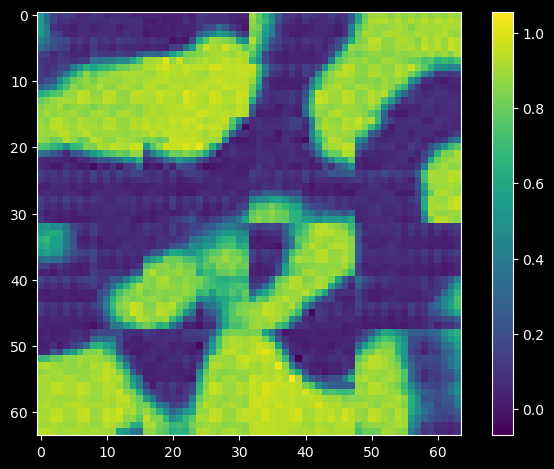

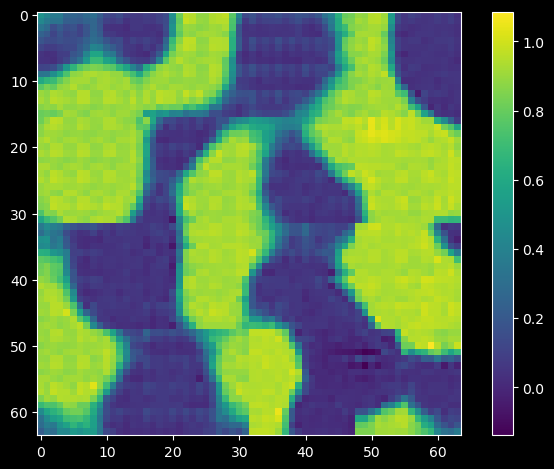

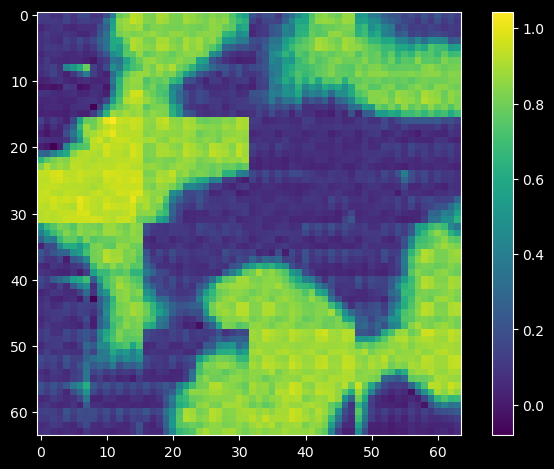

In [6]:
# Generate samples
num_samples = 8
key = random.PRNGKey(123)
eps_test = random.normal(key, (num_samples, config.eps_dim))
sample_fn = lambda params: model.state.decode_fn(params, eps_test)
samples = pmap(sample_fn)(model.state.params)[0,...]
print(samples.shape)

for i in range(num_samples):
    plt.figure()
    plt.imshow(jnp.flipud(samples[i,...]))
    plt.colorbar()
    plt.tight_layout()
    plt.savefig('./figures/sample_%d.png' % (i+1), dpi=300)
    plt.show()

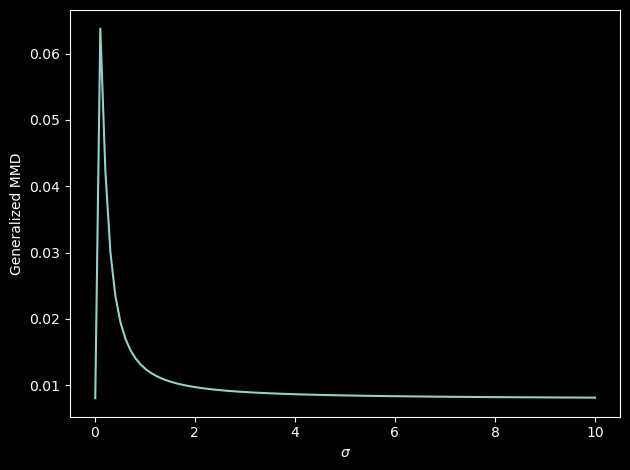

In [7]:
mmds = compute_mmd(config, model)

plt.figure()
plt.plot(jnp.linspace(1e-2,10,100), mmds)
plt.xlabel(r'$\sigma$')
plt.ylabel('Generalized MMD')
plt.tight_layout()
plt.show()